In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy import stats

# Model
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, KFold, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

# hyperparameter tuning
import optuna

In [2]:
try:
    kaggle_train_file_loc = "../input/playground-series-s4e11/train.csv"
    kaggle_test_file_loc = "../input/playground-series-s4e11/test.csv"
    df = pd.read_csv(kaggle_train_file_loc, index_col=0)
    df_test = pd.read_csv(kaggle_test_file_loc, index_col=0)
    
except:
    github_train_file_loc = "./dataset/train.csv"
    github_test_file_loc = "./dataset/test.csv"
    df = pd.read_csv(github_train_file_loc, index_col=0)
    df_test = pd.read_csv(github_test_file_loc, index_col=0)

# General Checks on the dataset

In [3]:
df.shape

(140700, 19)

In [14]:
df["Depression"].value_counts() / df.shape[0]

Depression
0    0.818287
1    0.181713
Name: count, dtype: float64

In [15]:
df.isna().sum()

Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  float

# Data Exploration

## Name, Gender, Age

There are no missing values for Name, Gender, and Age columns. We are just looking at value counts to ensure that the values that we observe in these columns are reasonable and what we would expect based on the description of the columns

<Axes: xlabel='Name', ylabel='count'>

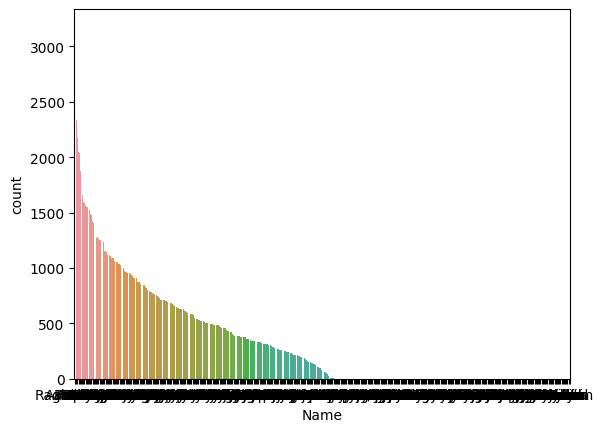

In [30]:
name_df = df["Name"].value_counts().reset_index() # 422 different names
sns.barplot(name_df, x="Name", y="count")

In [31]:
df["Name"].isna().sum()

0

In [33]:
# The plan is to one-hot-encode the first 200 names, and the rest are categorised as infrequent
df["Name"].value_counts().head(201)

Name
Rohan       3178
Aarav       2336
Rupak       2176
Aaradhya    2045
Anvi        2035
            ... 
Sneha        180
Bhavna       167
Ranveer      162
Rupa         151
Srishti      150
Name: count, Length: 201, dtype: int64

In [36]:
gender_grouped = df.groupby(["Gender", "Depression"])[['Name']].count().reset_index()
gender_grouped = gender_grouped.rename(columns={'Name':'count'})
gender_grouped['pct'] = gender_grouped['count'] * 100.0 / df.shape[0]
gender_grouped

,Gender,Depression,count,pct
0,Female,0,51965,36.933191
1,Female,1,11271,8.010661
2,Male,0,63168,44.895522
3,Male,1,14296,10.160625


<Axes: xlabel='Gender', ylabel='count'>

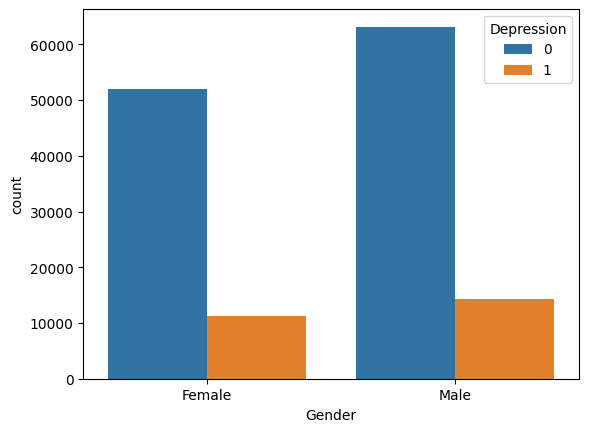

In [37]:
# Clean we have a good representation of males and females in this dataset.
# Approximately 18% of males and 22% of females have depression based on this dataset. Prevalence is fairly similar amongst the 2 genders.

sns.barplot(gender_grouped, x="Gender", y="count", hue='Depression')

<Axes: xlabel='Age', ylabel='count'>

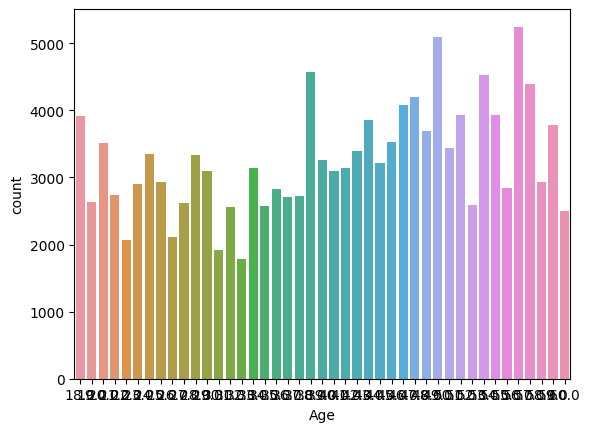

In [40]:
age_plot = pd.DataFrame(df["Age"].value_counts()).reset_index()

sns.barplot(age_plot, x="Age", y="count")
# We will perform a quantile-transform to transform the column to a gaussian-like distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Age', ylabel='Count'>

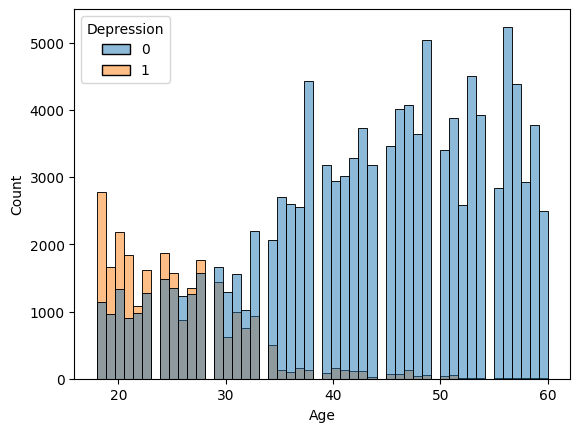

In [41]:
# we observe an interesting relationship between age and depression. Depression seem to be mroe prevalent amongst the younger population. 
# One can also question if it is a matter of depression being diagnosed amongst the older population due to a lack of knowledge?
# We can make further enquire about how this data is collected - Is it self-reported or collected from a medcial database in the hospital?
# The nature of self-reporting or a medical diagnosis of depression will provide more insights to how a conclusion can bw drawn from this chart.

sns.histplot(df, x="Age", hue='Depression')

## Cities

In [42]:
# we observe quite a number of incorrect data in this column, such as 'M.Tech' which is the name of a degree, 

# df["City"].nunique() #98 unique values
df["City"].unique()

array(['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur',
       'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot',
       'Jaipur', 'Pune', 'Lucknow', 'Meerut', 'Agra', 'Surat',
       'Faridabad', 'Hyderabad', 'Srinagar', 'Ghaziabad', 'Kolkata',
       'Chennai', 'Kalyan', 'Nagpur', 'Vadodara', 'Vasai-Virar', 'Delhi',
       'Bhopal', 'Indore', 'Ishanabad', 'Vidhi', 'Ayush', 'Gurgaon',
       'Krishna', 'Aishwarya', 'Keshav', 'Harsha', 'Nalini', 'Aditya',
       'Malyansh', 'Raghavendra', 'Saanvi', 'M.Tech', 'Bhavna',
       'Less Delhi', 'Nandini', 'M.Com', 'Plata', 'Atharv', 'Pratyush',
       'City', '3.0', 'Less than 5 Kalyan', 'MCA', 'Mira', 'Moreadhyay',
       'Morena', 'Ishkarsh', 'Kashk', 'Mihir', 'Vidya', 'Tolkata', 'Anvi',
       'Krinda', 'Ayansh', 'Shrey', 'Ivaan', 'Vaanya', 'Gaurav', 'Harsh',
       'Reyansh', 'Kashish', 'Kibara', 'Vaishnavi', 'Chhavi', 'Parth',
       'Mahi', 'Tushar', 'MSc', 'No', 'Rashi', 'ME', 'Molkata',
       'Researcher', '

In [44]:
# top 30 cities account for 140602, and the remaining 68 account for 98. We observe some errors in the city column which could be caused by a number of reasons - transposing error etc.
cities = df["City"].value_counts().head(30)
cities.sum()

140602

In [45]:
df["City"].value_counts().head(31)

City
Kalyan           6591
Patna            5924
Vasai-Virar      5765
Kolkata          5689
Ahmedabad        5613
Meerut           5528
Ludhiana         5226
Pune             5210
Rajkot           5207
Visakhapatnam    5176
Srinagar         5074
Mumbai           4966
Indore           4872
Agra             4684
Surat            4636
Varanasi         4606
Vadodara         4568
Hyderabad        4496
Kanpur           4398
Jaipur           4328
Thane            4289
Lucknow          4280
Nagpur           4209
Bangalore        4123
Chennai          4044
Ghaziabad        3620
Delhi            3593
Bhopal           3475
Faridabad        3268
Nashik           3144
Mihir               7
Name: count, dtype: int64

In [46]:
cities_list = df["City"].value_counts().head(30).index
df.query("City not in @cities_list").isna().sum()

# df.query("City not in @cities_list")["Depression"].sum() # 19 out of 98 have Depression (19.3%) which is fairly similar to the dataset's 18.1%

Name                                      0
Gender                                    0
Age                                       0
City                                      0
Working Professional or Student           0
Profession                               28
Academic Pressure                        72
Work Pressure                            26
CGPA                                     72
Study Satisfaction                       72
Job Satisfaction                         26
Sleep Duration                            0
Dietary Habits                            0
Degree                                    0
Have you ever had suicidal thoughts ?     0
Work/Study Hours                          0
Financial Stress                          0
Family History of Mental Illness          0
Depression                                0
dtype: int64

## CGPA (Suggest to remove?)

In [47]:
df["CGPA"].notna().sum() / df["CGPA"].shape[0]

0.19828002842928216

In [48]:
# we take a look at the potential differences in CGPA beteen a student with depression and a student without.

df.query("Depression == 1")["CGPA"].mean(), df.query("Depression == 0")["CGPA"].mean()

(7.685406617286974, 7.620812143227817)

The Mann Whitney U test suggests that there are difference in CGPA between people with depression and people without

In [49]:
mannwhitneyu(df[df["CGPA"].notna()].query("Depression == 0")["CGPA"], df[df["CGPA"].notna()].query("Depression == 1")["CGPA"])

MannwhitneyuResult(statistic=92054552.5, pvalue=0.00032127284999336757)

If you take a look at thatdvisualisation, they are actually pretty similar in trends

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='CGPA', ylabel='Count'>

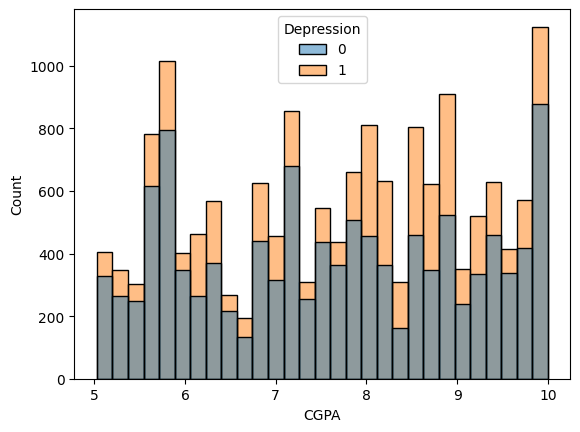

In [50]:
sns.histplot(df, x="CGPA", hue='Depression')

Ultimately, the lack of data is the primary reason to why we should consider dropping this column

## Profession

- The intention is to combine the `Working Professional or Student` and `Profession` columns to remove (or minimise) missing values in the profession column. We first determine if there are any extra information contained in both columns such that a simple merge of the 2 columns cannot be easily done.

In [51]:
professional = df[df["Working Professional or Student"] != "Student"]
professional.shape[0]

112799

In [52]:
professional[professional["Working Professional or Student"].isna() & professional["Profession"].isna()]

# If you are a professional, there are 0 rows that has both columns "working professional or student" and "Profession" omitted

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,


In [53]:
student_df = df[df["Working Professional or Student"] == "Student"]
student_df.shape[0]

27901

In [54]:
student_df.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
8,Aishwarya,Female,24.0,Bangalore,Student,NaN,2.0,NaN,5.90,5.0,NaN,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
26,Aditya,Male,31.0,Srinagar,Student,NaN,3.0,NaN,7.03,5.0,NaN,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
30,Prisha,Female,28.0,Varanasi,Student,NaN,3.0,NaN,5.59,2.0,NaN,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
32,Chhavi,Female,25.0,Jaipur,Student,NaN,4.0,NaN,8.13,3.0,NaN,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [55]:
student_df[student_df["Working Professional or Student"].notna() & student_df["Profession"].notna()].head()

# There are 34 entries that include the nature of professional on top of a student. For these 34 students, we will omit their profession since it the student profession is the more important professional here.

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
609,Anand,Male,21.0,Ahmedabad,Student,Civil Engineer,5.0,NaN,7.83,1.0,NaN,5-6 hours,Healthy,MSc,Yes,11.0,3.0,Yes,1
2105,Shreya,Female,31.0,Vadodara,Student,Architect,5.0,NaN,6.95,3.0,NaN,Less than 5 hours,Moderate,BSc,No,8.0,1.0,Yes,1
9483,Vidya,Female,32.0,Kalyan,Student,UX/UI Designer,3.0,NaN,9.60,2.0,NaN,7-8 hours,Moderate,PhD,Yes,5.0,3.0,No,1
11470,Anjali,Female,28.0,Ahmedabad,Student,Digital Marketer,5.0,NaN,9.72,3.0,NaN,More than 8 hours,Healthy,MA,Yes,10.0,5.0,Yes,1
12425,Rupak,Male,25.0,Kalyan,Student,Content Writer,5.0,NaN,8.50,2.0,NaN,5-6 hours,Moderate,B.Ed,Yes,0.0,2.0,Yes,1


In [56]:
# We have an unaccounted ~9k rows that are working professionals but do not have a profession
# We will asssume that they are unemployed

df[(df["Working Professional or Student"] == 'Working Professional') & pd.isna(df["Profession"])].shape[0]

8763

In [57]:
# we create a simple function to merge the 2 columns together.
def combine_profession(row):
    if (row["Working Professional or Student"] != 'Student') and (pd.isna(row["Profession"])):
        return 'Unemployed'
    elif row["Working Professional or Student"] != "Student":
        return row["Profession"]
    else:
        return "Student"

In [58]:
# we will remove rows containing these values in the Profession column
df.apply(combine_profession, axis=1).value_counts().tail(65 - 38)

Academic                5
Profession              3
BCA                     3
Yogesh                  3
LLM                     2
PhD                     2
MBA                     2
Dev                     1
Unveil                  1
Visakhapatnam           1
Pranav                  1
Analyst                 1
M.Ed                    1
Moderate                1
Nagpur                  1
B.Ed                    1
MBBS                    1
Patna                   1
Working Professional    1
Medical Doctor          1
BBA                     1
City Manager            1
FamilyVirar             1
Family Consultant       1
B.Com                   1
BE                      1
Yuvraj                  1
Name: count, dtype: int64

In [59]:
df.apply(combine_profession, axis=1).value_counts().tail(65 - 38).index

Index(['Academic', 'Profession', 'BCA', 'Yogesh', 'LLM', 'PhD', 'MBA', 'Dev',
       'Unveil', 'Visakhapatnam', 'Pranav', 'Analyst', 'M.Ed', 'Moderate',
       'Nagpur', 'B.Ed', 'MBBS', 'Patna', 'Working Professional',
       'Medical Doctor', 'BBA', 'City Manager', 'FamilyVirar',
       'Family Consultant', 'B.Com', 'BE', 'Yuvraj'],
      dtype='object')

## Work and Academic Pressure

<Axes: xlabel='Academic Pressure', ylabel='Count'>

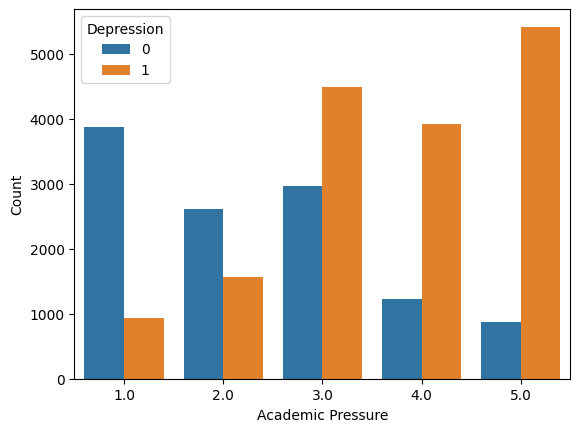

In [60]:
# we observe that an academic pressure of 1 represents least pressure and 5 represents most pressure. 
# The count of depression incidence incrases with increasing academic pressure

acad_pressure_grouped = df[df["Academic Pressure"].notna()].groupby(["Academic Pressure", "Depression"])[["Name"]].count().reset_index().rename(columns={"Name":"Count"})

sns.barplot(acad_pressure_grouped, x='Academic Pressure', y='Count', hue='Depression')

<Axes: xlabel='Work Pressure', ylabel='Count'>

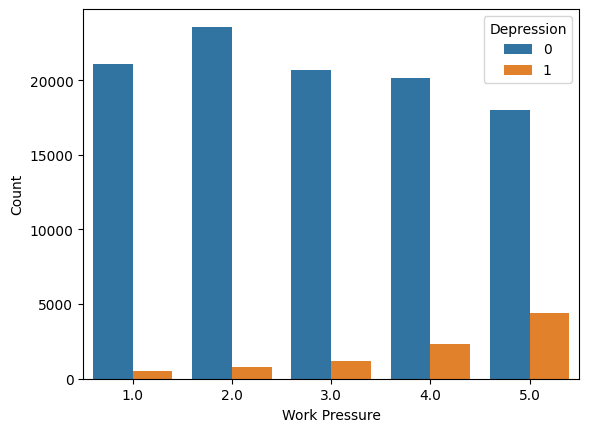

In [61]:
# The same trend is observed in work pressure. The count of depression incidence incrases with increasing work pressure
# however, the precentage of depression is significantly lower compared to when one is a student.

work_pressure_grouped = df[df["Work Pressure"].notna()].groupby(["Work Pressure", "Depression"])[["Name"]].count().reset_index().rename(columns={"Name":"Count"})

sns.barplot(work_pressure_grouped, x='Work Pressure', y='Count', hue='Depression')

In [63]:
# There are 21 rows without any academic or work pressure. We use imputation to convert to mode
df[df["Academic Pressure"].isna() & df["Work Pressure"].isna()].shape[0]

21

In [64]:
df["Academic Pressure"].notna().sum() + df["Work Pressure"].notna().sum()

140679

## City

In [67]:
# We observe a lot of incorrect input such as 'M.Com', 'Msc', etc.
df["City"].unique()
df["City"].nunique()

98

In [68]:
incorrect_city = df["City"].value_counts().tail(98-30).index
df.query("City in @incorrect_city")["City"].index

Index([   762,   1190,   2123,   3554,   3753,   8772,  12371,  15181,  17337,
        18496,  20886,  22215,  22293,  28672,  28862,  30231,  32706,  33276,
        33408,  33447,  34247,  34300,  35309,  36993,  38232,  38817,  39217,
        42134,  42470,  43050,  44087,  44166,  49098,  50691,  52500,  53366,
        55743,  55970,  55982,  57185,  58776,  60210,  61035,  61687,  63830,
        65042,  67795,  68667,  70407,  70668,  71144,  71995,  73510,  73571,
        74881,  75591,  76335,  77791,  78615,  82304,  82472,  83873,  86723,
        90669,  93066, 100484, 100610, 102845, 104952, 105684, 106809, 108304,
       108698, 109183, 112975, 114378, 115637, 115761, 116140, 116546, 116583,
       117760, 120908, 121908, 122708, 123642, 123668, 124395, 124637, 125192,
       125289, 126640, 126752, 129223, 132726, 136563, 137652, 138190],
      dtype='int64', name='id')

In [69]:
ohe = OneHotEncoder(sparse_output=True, handle_unknown="infrequent_if_exist", min_frequency=3000)
ohe.fit_transform(pd.DataFrame(df["City"]))
ohe.get_feature_names_out()

array(['City_Agra', 'City_Ahmedabad', 'City_Bangalore', 'City_Bhopal',
       'City_Chennai', 'City_Delhi', 'City_Faridabad', 'City_Ghaziabad',
       'City_Hyderabad', 'City_Indore', 'City_Jaipur', 'City_Kalyan',
       'City_Kanpur', 'City_Kolkata', 'City_Lucknow', 'City_Ludhiana',
       'City_Meerut', 'City_Mumbai', 'City_Nagpur', 'City_Nashik',
       'City_Patna', 'City_Pune', 'City_Rajkot', 'City_Srinagar',
       'City_Surat', 'City_Thane', 'City_Vadodara', 'City_Varanasi',
       'City_Vasai-Virar', 'City_Visakhapatnam',
       'City_infrequent_sklearn'], dtype=object)

Two potential solution exists:
1. We cull these rows from the dataset. They represent <1% of the dataset and at the same time we preserve the clealiness of the dataset
2. We rely on OneHotEncoder to turn these into `City-infrequent_sklearn`

We will use Solution #2 since the other rows are rather clean.

### Degree

Cleaning methods are prescribed later in the pre-processing section

In [70]:
df["Degree"].unique()

array(['BHM', 'LLB', 'B.Pharm', 'BBA', 'MCA', 'MD', 'BSc', 'ME', 'B.Arch',
       'BCA', 'BE', 'MA', 'B.Ed', 'B.Com', 'MBA', 'M.Com', 'MHM', 'BA',
       'Class 12', 'M.Tech', 'PhD', 'M.Ed', 'MSc', 'B.Tech', 'LLM',
       'MBBS', 'M.Pharm', 'UX/UI Designer', 'MPA', 'BH', 'Nalini', 'BEd',
       'B.Sc', 'Veda', 'Bhopal', 'S.Tech', 'Degree', '20', 'Class 11',
       'H_Pharm', 'M', 'P.Com', 'BPharm', 'Business Analyst', 'M.Arch',
       'LL.Com', 'Data Scientist', 'MPharm', 'L.Ed', 'P.Pharm', 'Kalyan',
       'Unite', 'BArch', 'HR Manager', 'Badhya', 'S.Pharm', 'LLBA',
       'Vrinda', 'M. Business Analyst', 'Bhavesh', '0', 'LLCom', '29',
       'MTech', 'Vivaan', 'BPA', 'Plumber', '5.61', 'Brit', 'B.03',
       'Ritik', '5.56', 'MEd', 'B', 'B BA', '7.06', 'B.B.Arch', 'ACA',
       'Brithika', 'CGPA', '24', 'M_Tech', 'Pihu', 'BB', 'Jhanvi',
       'LLTech', 'Aarav', 'Entrepreneur', '8.56', 'LHM', 'Lata', 'S.Arch',
       'Marsh', 'HCA', '5.88', 'B.Student', 'LL B.Ed', 'M.S', 'Navya',
   

In [71]:
df["Degree"].value_counts().head(27).index

Index(['Class 12', 'B.Ed', 'B.Arch', 'B.Com', 'B.Pharm', 'BCA', 'M.Ed', 'MCA',
       'BBA', 'BSc', 'MSc', 'LLM', 'M.Pharm', 'M.Tech', 'B.Tech', 'LLB', 'BHM',
       'MBA', 'BA', 'ME', 'MD', 'MHM', 'BE', 'PhD', 'M.Com', 'MBBS', 'MA'],
      dtype='object', name='Degree')

In [72]:
df["Degree"].value_counts().tail(88).index

Index(['M.Arch', 'UX/UI Designer', 'B.Sc', 'Kalyan', 'M', 'BArch', 'MEd',
       'BPharm', 'P.Com', 'Jhanvi', 'LLBA', 'Degree', 'B', 'Bhopal', 'BEd',
       'Nalini', 'LL B.Ed', 'L.Ed', '5.88', 'HCA', 'Marsh', 'S.Arch', 'Pihu',
       'Lata', 'LHM', '8.56', 'Entrepreneur', 'Aarav', 'LLTech', 'BB',
       'M_Tech', 'B.Student', 'E.Tech', 'M.S', 'Navya', 'Mihir', 'RCA',
       'B B.Com', 'LCA', 'N.Pharm', 'Doctor', 'CGPA', 'LLEd', 'LLS', 'Esha',
       'Working Professional', 'Mthanya', 'B.3.79', 'K.Ed', 'Mahika', '24',
       'Vrinda', 'Brithika', 'ACA', 'Badhya', 'HR Manager', 'Unite', 'P.Pharm',
       'MPharm', 'Data Scientist', 'LL.Com', 'Business Analyst', 'H_Pharm',
       'Class 11', '20', 'S.Tech', 'Veda', 'BH', 'MPA', 'S.Pharm',
       'M. Business Analyst', 'Bhavesh', 'Brit', 'B.B.Arch', '7.06', 'B BA',
       '5.56', 'Ritik', 'B.03', '5.61', '0', 'Plumber', 'BPA', 'Vivaan',
       'MTech', '29', 'LLCom', 'Advait'],
      dtype='object', name='Degree')

In [73]:
incorrect_degree = df["Degree"].value_counts().tail(88).index

df.query("Degree in @incorrect_degree")

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
1884,Sanket,Male,51.0,Ahmedabad,Working Professional,HR Manager,NaN,2.0,NaN,NaN,4.0,5-6 hours,Moderate,UX/UI Designer,No,7.0,3.0,Yes,0
3227,Rahil,Male,28.0,Varanasi,Student,NaN,4.0,NaN,5.66,4.0,NaN,More than 8 hours,Unhealthy,MPA,Yes,10.0,5.0,Yes,1
4337,Mihir,Male,28.0,Visakhapatnam,Student,NaN,1.0,NaN,7.94,4.0,NaN,Less than 5 hours,Unhealthy,BH,Yes,10.0,3.0,No,1
7885,Diya,Female,38.0,Ludhiana,Working Professional,Researcher,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Moderate,Nalini,Yes,5.0,1.0,No,0
8615,Rashi,Female,47.0,Nagpur,Working Professional,Content Writer,NaN,3.0,NaN,NaN,2.0,7-8 hours,Unhealthy,BEd,No,2.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137703,Darsh,Male,42.0,Lucknow,Working Professional,Chemist,NaN,4.0,NaN,NaN,4.0,5-6 hours,Moderate,BPharm,No,11.0,5.0,No,0
138190,Ivaan,Male,40.0,Unirar,Working Professional,Plumber,NaN,1.0,NaN,NaN,1.0,5-6 hours,Healthy,RCA,No,2.0,1.0,Yes,0
139446,Yogesh,Male,52.0,Mumbai,Working Professional,Researcher,NaN,5.0,NaN,NaN,4.0,7-8 hours,Moderate,Kalyan,No,5.0,3.0,Yes,0


In [74]:
df.query("Degree in @incorrect_degree").index

Index([  1884,   3227,   4337,   7885,   8615,   9719,   9923,  13315,  14834,
        15483,
       ...
       133347, 134561, 134938, 136760, 137281, 137703, 138190, 139446, 139862,
       139989],
      dtype='int64', name='id', length=114)

In [75]:
# initial data-cleaning function

def combine_profession(row):
    if row["Working Professional or Student"] != 'Student':
        return row["Profession"]
    else:
        return "Student"

def combine_pressure(row):
    if pd.isna(row["Academic Pressure"]) and pd.isna(row["Work Pressure"]):
        return np.nan
    elif pd.isna(row["Academic Pressure"]):
        return row["Work Pressure"]
    elif pd.isna(row["Work Pressure"]):
        return row["Academic Pressure"]

def combine_satisfaction(row):
    if pd.isna(row["Study Satisfaction"]) and pd.isna(row["Job Satisfaction"]):
        return np.nan
    elif pd.isna(row["Study Satisfaction"]):
        return row["Job Satisfaction"]
    elif pd.isna(row["Job Satisfaction"]):
        return row["Study Satisfaction"]

In [113]:
df["Profession"] = df.apply(combine_profession, axis=1)
df["Pressure"] = df.apply(combine_pressure, axis=1)
df["Satisfaction"] = df.apply(combine_satisfaction, axis=1)

### Study and Work Satisfaction

The assumption is that if you are working, you will have a job satisfaction, if you are studying, you have a study satisfaction

In [76]:
df["Study Satisfaction"].notna().sum() + df["Job Satisfaction"].notna().sum() +df[(df["Study Satisfaction"].isna() & df["Job Satisfaction"].isna())].shape[0]

140702

<Axes: xlabel='Study Satisfaction', ylabel='Count'>

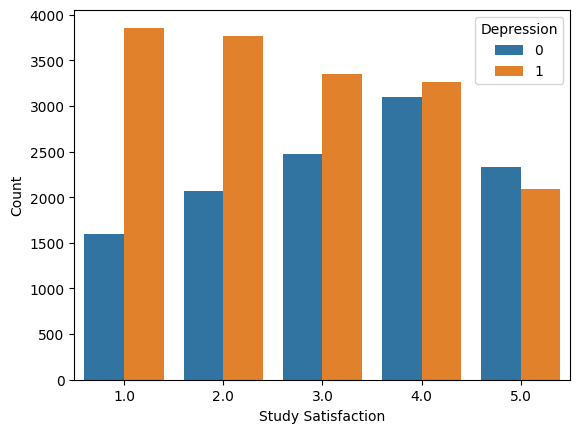

In [77]:
study_sat_df = df[df["Study Satisfaction"].notna()].groupby(["Study Satisfaction", "Depression"])[["Name"]].count().reset_index().rename(columns={'Name': "Count"})

sns.barplot(study_sat_df, x='Study Satisfaction', y='Count', hue='Depression')

<Axes: xlabel='Job Satisfaction', ylabel='Count'>

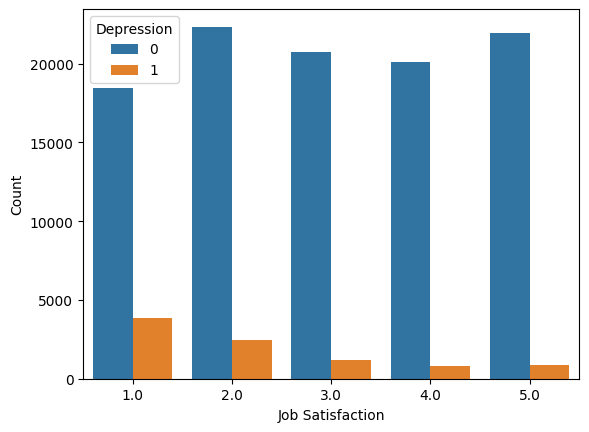

In [78]:
study_sat_df = (
    df[df["Job Satisfaction"].notna()]
    .groupby(["Job Satisfaction", "Depression"])[["Name"]]
    .count()
    .reset_index()
    .rename(columns={"Name": "Count"})
)

sns.barplot(study_sat_df, x="Job Satisfaction", y="Count", hue="Depression")

We observe a not-so-strong relationship between job/study satisfaction and depression

4 permutations arose - 
1. have job satisfaction but not study satisfaction (expected)
2. have study satisfaction but not job satisfaction (expected)
3. have both study and job satisfaction (unexpected), 2 entries
4. have none of study and job satisfaction (unexpected), 15 entries

In [86]:
(
    df[df["Study Satisfaction"].isna() & df["Job Satisfaction"].notna()].shape[0]
    + df[df["Study Satisfaction"].notna() & df["Job Satisfaction"].isna()].shape[0]
    + df[df["Study Satisfaction"].notna() & df["Job Satisfaction"].notna()].shape[0] # 2 entries
    + df[df["Study Satisfaction"].isna() & df["Job Satisfaction"].isna()].shape[0] # 15 entries
)

140700

In [87]:
df[df["Study Satisfaction"].notna() & df["Job Satisfaction"].notna()]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
1428,Rishi,Male,29.0,Srinagar,Student,NaN,3.0,NaN,9.63,3.0,3.0,7-8 hours,Moderate,M.Pharm,No,8.0,5.0,No,0
116703,Neil,Male,25.0,Bangalore,Student,NaN,4.0,NaN,9.44,5.0,2.0,Less than 5 hours,Unhealthy,PhD,Yes,4.0,1.0,No,1


In [563]:
df[df["Study Satisfaction"].isna() & df["Job Satisfaction"].isna()]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
17549,Tanya,Female,20.0,Patna,Student,NaN,NaN,NaN,5.55,NaN,NaN,5-6 hours,Moderate,Class 12,No,0.0,3.0,Yes,0
18344,Shivam,Male,30.0,Faridabad,Student,NaN,5.0,NaN,5.74,NaN,NaN,Less than 5 hours,Unhealthy,MCA,Yes,0.0,3.0,Yes,1
25647,Ishwar,Male,57.0,Kalyan,Working Professional,NaN,NaN,1.0,NaN,NaN,NaN,Less than 5 hours,Unhealthy,Class 12,No,4.0,1.0,No,0
34694,Kriti,Female,46.0,Meerut,Working Professional,NaN,NaN,NaN,NaN,NaN,NaN,5-6 hours,Moderate,Class 12,Yes,12.0,3.0,No,0
35612,Siddhesh,Male,27.0,Vadodara,Working Professional,NaN,NaN,NaN,NaN,NaN,NaN,Less than 5 hours,Unhealthy,B.Pharm,No,11.0,3.0,No,1
52199,Manan,Male,50.0,Agra,Working Professional,NaN,NaN,4.0,NaN,NaN,NaN,5-6 hours,Unhealthy,Class 12,No,1.0,3.0,Yes,0
55222,Trisha,Female,21.0,Varanasi,Working Professional,NaN,NaN,5.0,NaN,NaN,NaN,7-8 hours,Moderate,B.Arch,No,11.0,2.0,Yes,0
57196,Manvi,Female,20.0,Visakhapatnam,Working Professional,NaN,NaN,NaN,NaN,NaN,NaN,Less than 5 hours,Moderate,Class 12,No,0.0,4.0,Yes,1
58062,Ishita,Female,32.0,Vadodara,Student,NaN,5.0,NaN,NaN,NaN,NaN,Less than 5 hours,Unhealthy,Class 12,Yes,11.0,5.0,No,1


In [88]:
# we create a simple function to merge the 2 columns together.
def combine_profession(row):
    if (row["Working Professional or Student"] != "Student") and (
        pd.isna(row["Profession"])
    ):
        return "Unemployed"
    elif row["Working Professional or Student"] != "Student":
        return row["Profession"]
    else:
        return "Student"

### Sleep Duration

In [89]:
df["Sleep Duration"].nunique()

36

In [90]:
df["Sleep Duration"].value_counts()

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1-6 hours                4
No                       4
9-11 hours               2
10-11 hours              2
Sleep_Duration           2
Unhealthy                2
45                       2
8-9 hours                2
10-6 hours               1
9-5                      1
45-48 hours              1
3-6 hours                1
Work_Study_Hours         1
49 hours                 1
than 5 hours             1
Pune                     1
9-6 hours                1
8 hours                  1
35-36 hours              1
Indore                   1
1-3 hours                1
55-66 hours              1
Moderate                 1
40-45 hours              1
1-2 hours                1
9-5 hours                1
Name: count, 

Recategorise sleep using the most popular sleep duration categories

In [91]:
def clean_sleep_duration(row):
    if row["Sleep Duration"] in ["Less than 5 hours", "3-4 hours", "1-3 hours", "1-2 hours",'2-3 hours', '3-4 hours', '4-5 hours']:
        return "Less than 5 hours"
    elif row["Sleep Duration"] in ["9-11 hours", '10-11 hours', '8-9 hours', "More than 8 hours"]:
        return "More than 8 hours"
    elif row["Sleep Duration"] in ["6-8 hours", "5-6 hours", "7-8 hours", "6-8 hours", '6-7 hours', '8 hours']:
        return "5 to 8 hours"
    else:
        return "Others"

In [92]:
df.apply(clean_sleep_duration, axis=1).value_counts()

5 to 8 hours         69124
Less than 5 hours    38810
More than 8 hours    32732
Others                  34
Name: count, dtype: int64

In [94]:
df["Sleep"] = df.apply(clean_sleep_duration, axis=1)

<Axes: xlabel='Sleep', ylabel='Count'>

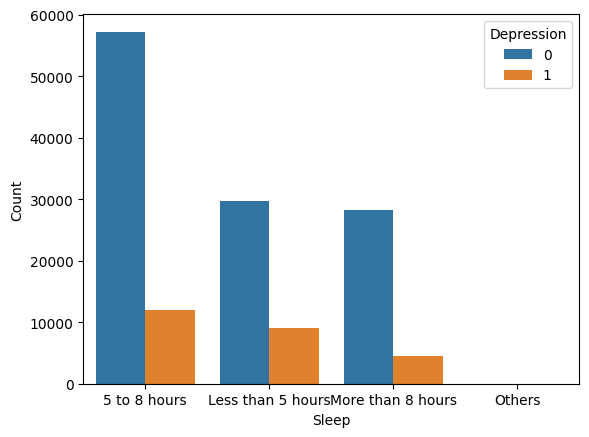

In [95]:
sleep_group = df.groupby(["Sleep", "Depression"])[["Name"]].count().reset_index().rename(columns={"Name":"Count"})
sns.barplot(sleep_group, x='Sleep', y='Count', hue='Depression')

In [96]:
sleep_group_copy = sleep_group.copy()

In [98]:
sleep_group_copy

,Sleep,Depression,Count
0,5 to 8 hours,0,0.827585
1,5 to 8 hours,1,0.172415
2,Less than 5 hours,0,0.765421
3,Less than 5 hours,1,0.234579
4,More than 8 hours,0,0.861237
5,More than 8 hours,1,0.138763
6,Others,0,0.911765
7,Others,1,0.088235


In [99]:
sleep_group_copy.loc[:1,"Count"] = sleep_group_copy.loc[:1, "Count"] / sleep_group_copy.loc[:1, "Count"].sum()
sleep_group_copy.loc[2:3, "Count"] = sleep_group_copy.loc[2:3, "Count"] / sleep_group_copy.loc[2:3, "Count"].sum()
sleep_group_copy.loc[4:5, "Count"] = sleep_group_copy.loc[4:5, "Count"] / sleep_group_copy.loc[4:5, "Count"].sum()
sleep_group_copy.loc[6:, "Count"] = sleep_group_copy.loc[6:, "Count"] / sleep_group_copy.loc[6:, "Count"].sum()

<Axes: xlabel='Sleep', ylabel='Count'>

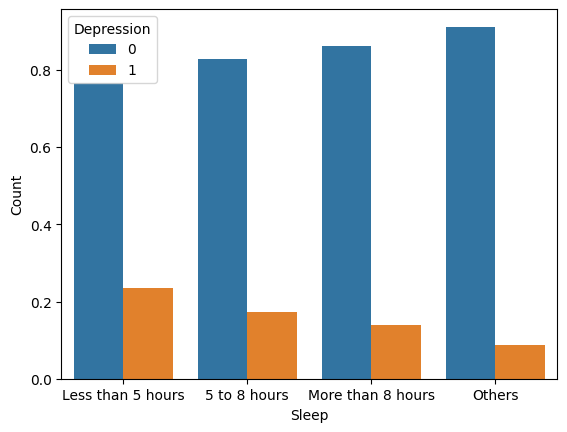

In [101]:
sns.barplot(sleep_group_copy, x="Sleep", y="Count", hue="Depression", order=['Less than 5 hours','5 to 8 hours', 'More than 8 hours', 'Others'])

### Dietary Habits

In [102]:
df["Dietary Habits"].value_counts()

Dietary Habits
Moderate             49705
Unhealthy            46227
Healthy              44741
Yes                      2
No                       2
More Healthy             2
No Healthy               1
Class 12                 1
Indoor                   1
Male                     1
Vegas                    1
M.Tech                   1
Less Healthy             1
1.0                      1
Electrician              1
Hormonal                 1
Mihir                    1
Less than Healthy        1
3                        1
Gender                   1
BSc                      1
Pratham                  1
2                        1
Name: count, dtype: int64

<Axes: xlabel='Dietary Habits', ylabel='Count'>

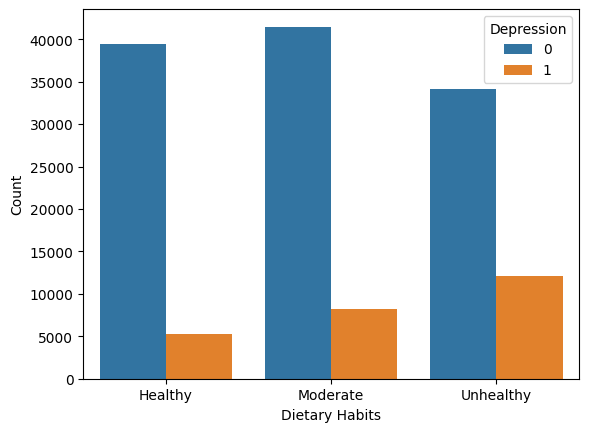

In [103]:
diet_categories = ['Moderate', "Healthy", "Unhealthy"]
diet_group = df.query("`Dietary Habits` in @diet_categories").groupby(["Dietary Habits", "Depression"])[["Name"]].count().reset_index().rename(columns={"Name": "Count"})

sns.barplot(diet_group, x="Dietary Habits", y="Count", hue="Depression")

We will rely on One Hot Encode to cull infequent labels

In [104]:
df["Dietary Habits"].value_counts()

Dietary Habits
Moderate             49705
Unhealthy            46227
Healthy              44741
Yes                      2
No                       2
More Healthy             2
No Healthy               1
Class 12                 1
Indoor                   1
Male                     1
Vegas                    1
M.Tech                   1
Less Healthy             1
1.0                      1
Electrician              1
Hormonal                 1
Mihir                    1
Less than Healthy        1
3                        1
Gender                   1
BSc                      1
Pratham                  1
2                        1
Name: count, dtype: int64

### Suicidal thoughts

In [105]:
df["Have you ever had suicidal thoughts ?"].value_counts()

Have you ever had suicidal thoughts ?
No     71138
Yes    69562
Name: count, dtype: int64

<Axes: xlabel='thoughts', ylabel='Count'>

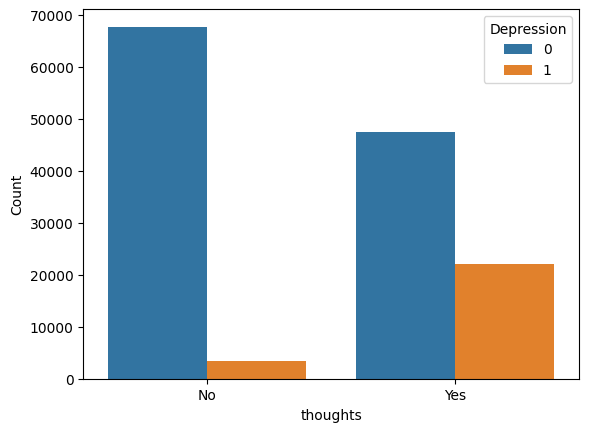

In [112]:
thoughts_group = (
    df.groupby(["Have you ever had suicidal thoughts ?", "Depression"])[["Name"]]
    .count()
    .reset_index()
    .rename(columns={"Name": "Count", "Have you ever had suicidal thoughts ?":"thoughts"})
)

sns.barplot(thoughts_group, x="thoughts", y="Count", hue="Depression")

### Work/Study hours

In [107]:
df["Work/Study Hours"].isna().sum()

0

In [108]:
df["Work/Study Hours"].value_counts()

Work/Study Hours
10.0    14199
11.0    12832
9.0     12711
0.0     12066
12.0    11409
2.0     10595
6.0     10432
7.0      9872
1.0      9802
3.0      9474
5.0      9337
4.0      9065
8.0      8906
Name: count, dtype: int64

<Axes: xlabel='work_hours', ylabel='Count'>

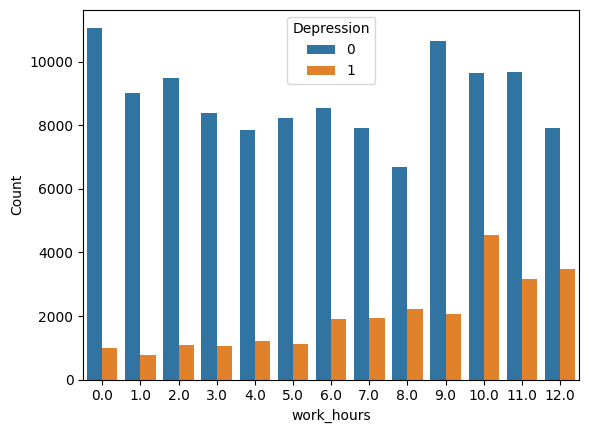

In [109]:
work_group = (
    df.groupby(["Work/Study Hours", "Depression"])[["Name"]]
    .count()
    .reset_index()
    .rename(
        columns={"Name": "Count", "Work/Study Hours": "work_hours"}
    )
)

sns.barplot(work_group, x="work_hours", y="Count", hue="Depression")

## Dietary Habits

In [115]:
print(df["Dietary Habits"].isna().sum())
df["Dietary Habits"].value_counts()

4


Dietary Habits
Moderate             49705
Unhealthy            46227
Healthy              44741
Yes                      2
No                       2
More Healthy             2
No Healthy               1
Class 12                 1
Indoor                   1
Male                     1
Vegas                    1
M.Tech                   1
Less Healthy             1
1.0                      1
Electrician              1
Hormonal                 1
Mihir                    1
Less than Healthy        1
3                        1
Gender                   1
BSc                      1
Pratham                  1
2                        1
Name: count, dtype: int64

In [123]:
diet_groups = df["Dietary Habits"].value_counts().head(3).index
diet_plot = df.query("`Dietary Habits` in @diet_groups").groupby(["Dietary Habits", "Depression"])[["Name"]].count().reset_index().rename(columns={"Name":"Count", "Dietary Habits":"Diet"})

<Axes: xlabel='Diet', ylabel='Count'>

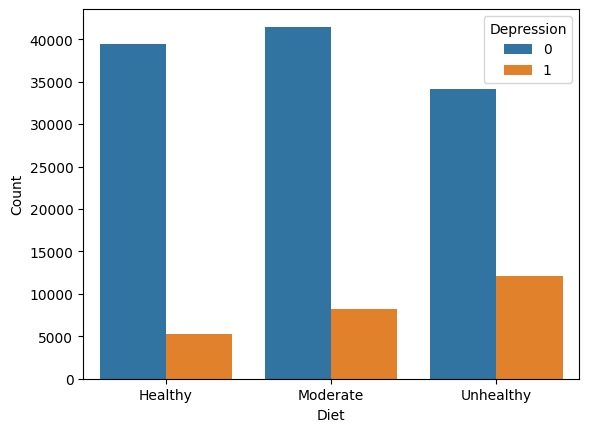

In [124]:
sns.barplot(diet_plot, x="Diet", y="Count", hue="Depression")

## Financial Stress

In [125]:
df["Financial Stress"].value_counts()

Financial Stress
2.0    31451
5.0    28279
4.0    27765
1.0    27211
3.0    25990
Name: count, dtype: int64

<Axes: xlabel='work_hours', ylabel='Count'>

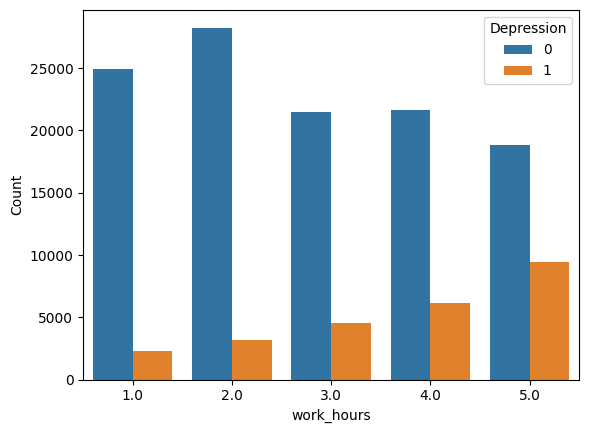

In [126]:
financial_stress_group = (
    df.groupby(["Financial Stress", "Depression"])[["Name"]]
    .count()
    .reset_index()
    .rename(columns={"Name": "Count", "Financial Stress": "work_hours"})
)

sns.barplot(financial_stress_group, x="work_hours", y="Count", hue="Depression")

## Family History

In [127]:
df["Family History of Mental Illness"].value_counts()

Family History of Mental Illness
No     70758
Yes    69942
Name: count, dtype: int64

<Axes: xlabel='fam_hist', ylabel='Count'>

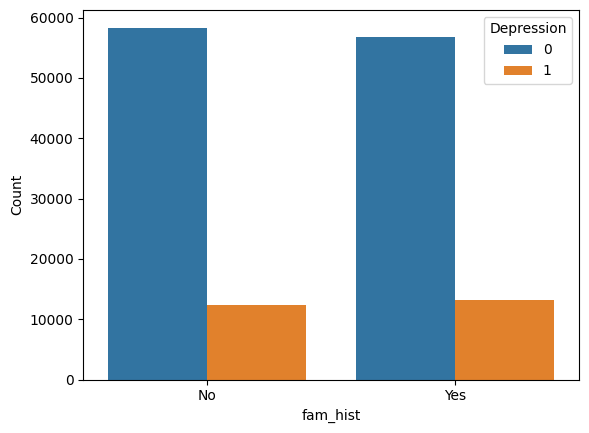

In [128]:
fam_hist_group = (
    df.groupby(["Family History of Mental Illness", "Depression"])[["Name"]]
    .count()
    .reset_index()
    .rename(columns={"Name": "Count", "Family History of Mental Illness": "fam_hist"})
)

sns.barplot(fam_hist_group, x="fam_hist", y="Count", hue="Depression")

# Building a Preprocessing pipeline

1. Combine Profession
2. Combine Work + Academic Pressure
3. Study + Job Satisfaction
4. Clean Sleep Duration
5. Clean Degree
6. Separate Degree into Qualification and Field of Study

In [28]:
def combine_profession(row):
    if (row["Working Professional or Student"] != 'Student') and (pd.isna(row["Profession"])):
        # We make a huge assumption that working professionals with missing professions are unemployed.
        return 'Unemployed'
    elif row["Working Professional or Student"] != "Student":
        return row["Profession"]
    else:
        return "Student"

def combine_pressure(row):
    # Idea is to reduce the number of missing data since both columns are complementary.
    # Note that despite combining there are still rows that contain missing values and we will rely on simple imputation to fill missing values
    if pd.notna(row["Academic Pressure"]) and pd.isna(row["Work Pressure"]):
        return row["Academic Pressure"]
    elif pd.isna(row["Academic Pressure"]) and pd.notna(row["Work Pressure"]):
        return row["Work Pressure"]

def combine_satisfaction(row):
    # Idea is to reduce the number of missing data since both columns are complementary.
    # Note that despite combining there are still rows that contain missing values and we will rely on simple imputation to fill missing values
    
    if pd.notna(row["Study Satisfaction"]) and pd.isna(row["Job Satisfaction"]):
        return row["Study Satisfaction"]
    elif pd.isna(row["Study Satisfaction"]) and pd.notna(row["Job Satisfaction"]):
        return row["Job Satisfaction"]

def clean_sleep_duration(row):
    if row["Sleep Duration"] in ["Less than 5 hours", "3-4 hours", "1-3 hours", "1-2 hours",'2-3 hours', '3-4 hours', '4-5 hours']:
        return "Less than 5 hours"
    elif row["Sleep Duration"] in ["9-11 hours", '10-11 hours', '8-9 hours', "More than 8 hours"]:
        return "More than 8 hours"
    elif row["Sleep Duration"] in ["6-8 hours", "5-6 hours", "7-8 hours", "6-8 hours", '6-7 hours', '8 hours']:
        return "5 to 8 hours"
    else:
        return "Others"

# def clean_sleep_duration(row):
#     sleep={
#             "More than 8 hours":9,
#             'Less than 5 hours':4,
#             '5-6 hours':5.5,
#             '7-8 hours':7.5,
#             '1-2 hours':1.5,
#             '6-8 hours':7,
#             '4-6 hours':5,
#             '6-7 hours':6.5,
#             '10-11 hours':10.5,
#             '8-9 hours':8.5,
#             '9-11 hours':10,
#             '2-3 hours':2.5,
#             '3-4 hours':3.5,
#             'Moderate':6,
#             '4-5 hours':4.5,
#             '9-6 hours':7.5,
#             '1-3 hours':2,
#             '1-6 hours':4,
#             '8 hours':8,
#             '10-6 hours':8,
#             'Unhealthy':3,
#             'Work_Study_Hours':6,
#             '3-6 hours':3.5,
#             '9-5':7,
#             '9-5 hours':7,
#     }
#     return sleep.get(row["Sleep Duration"])


def clean_degree(row):
    degree = {
        "BCom": "B.Com",
        "B.Com": "B.Com",
        "B.Comm": "B.Com",
        "B.Tech": "B.Tech",
        "BTech": "B.Tech",
        "B.T": "B.Tech",
        "BSc": "B.Sc",
        "B.Sc": "B.Sc",
        "Bachelor of Science": "B.Sc",
        "BArch": "B.Arch",
        "B.Arch": "B.Arch",
        "BA": "B.A",
        "B.A": "B.A",
        "BBA": "BBA",
        "BB": "BBA",
        "BCA": "BCA",
        "BE": "BE",
        "BEd": "B.Ed",
        "B.Ed": "B.Ed",
        "BPharm": "B.Pharm",
        "B.Pharm": "B.Pharm",
        "BHM": "BHM",
        "LLB": "LLB",
        "LL B": "LLB",
        "LL BA": "LLB",
        "LL.Com": "LLB",
        "LLCom": "LLB",
        "MCom": "M.Com",
        "M.Com": "M.Com",
        "M.Tech": "M.Tech",
        "MTech": "M.Tech",
        "M_Tech": "M.Tech", 
        "M.T": "M.Tech",
        "MSc": "M.Sc",
        "M.Sc": "M.Sc",
        "Master of Science": "M.Sc",
        "MBA": "MBA",
        "MCA": "MCA",
        "MD": "MD",
        "ME": "ME",
        "MEd": "M.Ed",
        "M.Ed": "M.Ed",
        "MArch": "M.Arch",
        "M.Arch": "M.Arch",
        "MPharm": "M.Pharm",
        "M.Pharm": "M.Pharm",
        "MA": "MA",
        "M.A": "MA",
        "MHM": "MHM",
        "MPA": "MPA",
        "LLM": "LLM",
        "PhD": "PhD",
        "MBBS": "MBBS",
        "CA": "CA",
        "Class 12": "Class 12",
        "12th": "Class 12",
        "Class 11": "Class 11",
        "11th": "Class 11",
    }
    return degree.get(row["Degree"])

def create_qualification(row):
    if row["Degree"] in ["Class 12", "Class 11"]:
        return "High School"
    elif row["Degree"] in ["B.Ed", "B.Arch", "B.Com", "B.Pharm", "BCA", "BBA", "B.Sc", "LLB", "B.Tech", "B.A", "BE", "MBBS", "BHM"]:
        return "Bachelor"
    elif row["Degree"] in ["M.Ed", "MCA", "LLM", "M.Sc", "M.Tech", "M.Pharm", "MBA", "ME", "MD", "M.Com", "MA", "M.Arch", "MPA", "MHM"]:
        return "Masters"
    elif row["Degree"] == "PhD":
        return "PhD"

def create_field_of_study(row):
    if row["Degree"] in ["Class 12", "Class 11", "MPA"]:
        # MPA is given an unknown here because there is only 1 record of MPA
        return "General"
    elif row["Degree"] in ["PhD"]:
        return "Specialist"
    elif row["Degree"] in ["B.Ed", "M.Ed"]:
        return "Education"
    elif row["Degree"] in ["B.Arch", "M.Arch"]:
        return "Architecture"
    elif row["Degree"] in ["B.Com", "M.Com"]:
        return "Commerce"
    elif row["Degree"] in ["B.Pharm", "M.Pharm"]:
        return "Pharmacy"
    elif row["Degree"] in ["BCA", "MCA"]:
        return "Computer Application"
    elif row["Degree"] in ["BBA", "MBA"]:
        return "Business Administration"    
    elif row["Degree"] in ["B.Sc", "M.Sc"]:
        return "Science"
    elif row["Degree"] in ["B.Sc", "M.Sc"]:
        return "Science"
    elif row["Degree"] in ["LLB", "LLM"]:
        return "Law"
    elif row["Degree"] in ["B.Tech", "M.Tech"]:
        return "Technology"
    elif row["Degree"] in ["BHM", "MHM"]:
        return "Hospitality"
    elif row["Degree"] in ["B.A", "MA"]:
        return "Arts"
    elif row["Degree"] in ["ME", "BE"]:
        return "Engineering"
    elif row["Degree"] in ["MD", "MBBS"]:
        return "Medicine"


# def clean_diet(row):
#     diet = {
#         "More Healthy": 0,
#         "Healthy": 1,
#         "Less than Healthy": 2,
#         "Less Healthy": 2,
#         "Moderate": 3,
#         "Unhealthy": 4,
#         "No Healthy": 4,
#     }
#     if diet.get(row["Dietary Habits"]):
#         return diet.get(row["Dietary Habits"])
#     else:
#         return pd.NA

def manipulate_dataframe(df):
    result = df.copy()
    result["Profession"] = result.apply(combine_profession, axis=1)
    result["Pressure"] = result.apply(combine_pressure, axis=1)
    result["Satisfaction"] = result.apply(combine_satisfaction, axis=1)
    result["Sleep"] = result.apply(clean_sleep_duration, axis=1)
    # result["Diet"] = result.apply(clean_diet, axis=1)
    result["Degree"] = result.apply(clean_degree, axis=1)
    result["Qualification"] = result.apply(create_qualification, axis=1)
    result["Subject"] = result.apply(create_field_of_study, axis=1)

    # # this one omits the dietary habits
    # result = result.drop(["Name", 'Working Professional or Student', "Academic Pressure", "Work Pressure", "Study Satisfaction", "Job Satisfaction", "Sleep Duration", "CGPA", "Dietary Habits", "Degree"], axis=1)
    
    # this variant includes Dietary Habits and Name
    result = result.rename(columns={"Dietary Habits":"Diet"})
    result = result.drop(['Working Professional or Student', "Academic Pressure", "Work Pressure", "Study Satisfaction", "Job Satisfaction", "Sleep Duration", "CGPA", "Degree"], axis=1)

    # # This variant includes Dietary Habits but omits name
    # result = result.rename(columns={"Dietary Habits":"Diet"})
    # result = result.drop(["Name", 'Working Professional or Student', "Academic Pressure", "Work Pressure", "Study Satisfaction", "Job Satisfaction", "Sleep Duration", "CGPA", "Degree"], axis=1)

    return result

In [31]:
prep_df = manipulate_dataframe(df)
X = prep_df.drop(columns="Depression")
y = prep_df.loc[:, "Depression"]
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
# categorical values, require imputation, one hot encoding
cat_multiple_impute_ohe_list = ["Diet", "Qualification", "Subject"]
cat_multiple_impute_ohe_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', min_frequency=300))
])

# categorical values, no imputation, one hot encoding
# cat_multiple_ohe_list = ["City", "Profession", "Sleep"]
cat_multiple_ohe_list = ["City", "Profession", "Sleep", "Name"]
cat_multiple_ohe_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', min_frequency=150))
])

# binary values, no imputation
cat_binary_ohe_list = ["Gender","Have you ever had suicidal thoughts ?","Family History of Mental Illness",]
cat_binary_ohe_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, drop='if_binary'))
])

# numberical values, require imputation, quantile transform
num_qtrns_list = ["Work/Study Hours", "Age"]
num_impute_qtransform_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
    ('quantile_transform', QuantileTransformer(output_distribution='normal'))
])

# numberical values, no imputation, quantile transform
num_impute_qtranse_list = ["Pressure","Satisfaction","Financial Stress"]
num_qtransform_pipeline = Pipeline([
    ('quantile_transform', QuantileTransformer(output_distribution='normal'))
])

ct = ColumnTransformer([
    ('categorical_impute', cat_multiple_impute_ohe_pipeline, cat_multiple_impute_ohe_list),
    ('categorical_mul', cat_multiple_ohe_pipeline, cat_multiple_ohe_list),
    ('categorical_binary', cat_binary_ohe_pipeline, cat_binary_ohe_list),
    ('numerical_impute', num_impute_qtransform_pipeline, num_impute_qtranse_list),
    ('numerical_transform', num_qtransform_pipeline, num_qtrns_list)
], remainder='drop')

### Optuna

In [38]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1500),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.01, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    pipe_xgb = Pipeline(
        [("preprocessing", ct), ("model", XGBClassifier(**params, booster="gbtree"))]
    )

    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(
        pipe_xgb, X, y, cv=stratified_kfold, scoring="roc_auc", n_jobs=-1
    )

    return auc_scores.mean()

In [40]:
# Define EarlyStoppingCallback for Optuna
class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.no_improvement_trials = 0
        self.best_value = -np.inf

    def __call__(self, study, trial):
        if study.best_value > self.best_value:
            self.best_value = study.best_value
            self.no_improvement_trials = 0
        else:
            self.no_improvement_trials += 1

        if self.no_improvement_trials >= self.patience:
            print(
                f"Early stopping triggered. No improvement after {self.patience} trials."
            )
            study.stop()

In [41]:
early_stopping = EarlyStoppingCallback(patience=70)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300, callbacks=[early_stopping])

[I 2024-11-18 14:18:16,750] A new study created in memory with name: no-name-f7a4750f-aa8e-489c-8336-625aae87244e
[I 2024-11-18 14:18:45,182] Trial 0 finished with value: 0.9756996026652145 and parameters: {'n_estimators': 436, 'max_depth': 7, 'learning_rate': 0.10227887382554002, 'subsample': 0.4951706439448945, 'colsample_bytree': 0.11466216072595249, 'gamma': 0.3323641382902782, 'min_child_weight': 17}. Best is trial 0 with value: 0.9756996026652145.
[I 2024-11-18 14:19:21,725] Trial 1 finished with value: 0.9751549060805527 and parameters: {'n_estimators': 1141, 'max_depth': 1, 'learning_rate': 0.14790510452604216, 'subsample': 0.184052622768783, 'colsample_bytree': 0.8240735375476459, 'gamma': 0.4548410651041579, 'min_child_weight': 9}. Best is trial 0 with value: 0.9756996026652145.
[I 2024-11-18 14:20:04,373] Trial 2 finished with value: 0.9664299874928906 and parameters: {'n_estimators': 453, 'max_depth': 19, 'learning_rate': 0.3803815778948177, 'subsample': 0.7547998711254759,

In [44]:
best_params = study.best_params
# best_params = {'n_estimators': 623,
#  'max_depth': 6,
#  'learning_rate': 0.04337168717098735,
#  'subsample': 0.5762710438011511,
#  'colsample_bytree': 0.19790812731138763,
#  'gamma': 0.22686965140524085,
#  'min_child_weight': 3}

In [45]:
best_params

{'n_estimators': 623,
 'max_depth': 6,
 'learning_rate': 0.04337168717098735,
 'subsample': 0.5762710438011511,
 'colsample_bytree': 0.19790812731138763,
 'gamma': 0.22686965140524085,
 'min_child_weight': 3}

In [46]:
# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_parallel_coordinate(study)
# optuna.visualization.plot_slice(study)
optuna.visualization.plot_param_importances(study)

In [145]:
test_df = manipulate_dataframe(df_test)
test_df

,Name,Gender,Age,City,Profession,Diet,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Pressure,Satisfaction,Sleep,Qualification,Subject
id,,,,,,,,,,,,,,,
140700,Shivam,Male,53.0,Visakhapatnam,Judge,Moderate,No,9.0,3.0,Yes,2.0,5.0,Less than 5 hours,Bachelor,Law
140701,Sanya,Female,58.0,Kolkata,Educational Consultant,Moderate,No,6.0,4.0,No,2.0,4.0,Less than 5 hours,Bachelor,Education
140702,Yash,Male,53.0,Jaipur,Teacher,Moderate,Yes,12.0,4.0,No,4.0,1.0,5 to 8 hours,Bachelor,Architecture
140703,Nalini,Female,23.0,Rajkot,Student,Moderate,Yes,10.0,4.0,No,5.0,1.0,More than 8 hours,Bachelor,Science
140704,Shaurya,Male,47.0,Kalyan,Teacher,Moderate,Yes,3.0,4.0,No,5.0,5.0,5 to 8 hours,Bachelor,Computer Application
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234495,Zoya,Female,49.0,Jaipur,Pilot,Moderate,Yes,2.0,2.0,Yes,3.0,5.0,Less than 5 hours,Bachelor,Science
234496,Shlok,Male,29.0,Ahmedabad,Pilot,Moderate,Yes,11.0,3.0,Yes,5.0,1.0,5 to 8 hours,Bachelor,Engineering
234497,Rishi,Male,24.0,Visakhapatnam,Student,Moderate,No,7.0,1.0,No,1.0,4.0,5 to 8 hours,Bachelor,Technology


In [ ]:
# ct = ColumnTransformer([
#     ('categorical_impute', cat_multiple_impute_ohe_pipeline, cat_multiple_impute_ohe_list),
#     ('categorical_mul', cat_multiple_ohe_pipeline, cat_multiple_ohe_list),
#     ('categorical_binary', cat_binary_ohe_pipeline, cat_binary_ohe_list),
#     ('numerical_impute', num_impute_qtransform_pipeline, num_impute_qtranse_list),
#     ('numerical_transform', num_qtransform_pipeline, num_qtrns_list)
# ], remainder='drop')

In [144]:
pipe_xgb = Pipeline(
    [("preprocessing", ct), ("model", XGBClassifier(**best_params, booster="gbtree"))]
)

pipe_xgb.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical_impute',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(missing_values=<NA>,
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=150,
                                                                                 sparse_output=False))]),
                                                  ['Diet', 'Qualification',
                                                   'Subject']),
                                                 ('categorical_mul',
                                                  Pipeline(steps=[...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.06712082655416732, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=507, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [148]:
# submission
test_df["pred"] = pipe_xgb.predict(test_df)
test_df.loc[:, ["pred"]].to_csv("submission.csv")

### RandomSearchCV

In [1040]:
# clf_xgb = Pipeline([
#     ('preprocessing', ct),
#     ('model', XGBClassifier())
# ])
# param_dist = {
#     "model__n_estimators": stats.randint(100, 500),
#     "model__learning_rate": stats.uniform(0.01, 0.8),
#     "model__subsample": stats.uniform(0.2, 0.8),
#     "model__max_depth": stats.randint(1, 10),
#     "model__colsample_bytree": stats.uniform(0.1, 1),
#     "model__min_child_weight": [1, 2, 3, 4],
# }

# numFolds = 5
# kfold_5 = RepeatedStratifiedKFold(n_splits=numFolds, n_repeats=5)

# clf = RandomizedSearchCV(
#     clf_xgb,
#     param_distributions=param_dist,
#     cv=kfold_5,
#     n_iter=100,
#     scoring="roc_auc",
#     error_score=0,
#     verbose=3,
#     n_jobs=-1,
# )

# clf.fit(X, y)